# Active acoustic data analysis for 18Hz **and** 38Hz data
**Explore data :** 
1) **Data structure** : NetCDF4 : its variables
2) **Time dimension** : How many sample by seasons / year ? At what time was the data recorded ?
3) **Space dimension** : Where was the data recorded ?
4) **Time and space dimensions** : The data at the time and location it was recorded

#### Imports

In [35]:
%load_ext autoreload
%autoreload 2
import data_extraction_functions as script_func

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [36]:
import netCDF4 as nc
import os
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Dict, Tuple
import datetime
import pandas as pd
import xarray as xr

## Explore data

## **1) Data structure**

### Test de xarray

In [37]:
list_cdf_files=script_func.get_list_files() # Open folder containing all nc files and get list of all nc files path
dataset_xr = script_func.open_dataset_xr(3, list_cdf_files)
depth = dataset_xr["DEPTH"]
print(depth.values)
script_func.close_dataset(dataset_xr)

[   2.5    7.5   12.5   17.5   22.5   27.5   32.5   37.5   42.5   47.5
   52.5   57.5   62.5   67.5   72.5   77.5   82.5   87.5   92.5   97.5
  102.5  107.5  112.5  117.5  122.5  127.5  132.5  137.5  142.5  147.5
  152.5  157.5  162.5  167.5  172.5  177.5  182.5  187.5  192.5  197.5
  202.5  207.5  212.5  217.5  222.5  227.5  232.5  237.5  242.5  247.5
  252.5  257.5  262.5  267.5  272.5  277.5  282.5  287.5  292.5  297.5
  302.5  307.5  312.5  317.5  322.5  327.5  332.5  337.5  342.5  347.5
  352.5  357.5  362.5  367.5  372.5  377.5  382.5  387.5  392.5  397.5
  402.5  407.5  412.5  417.5  422.5  427.5  432.5  437.5  442.5  447.5
  452.5  457.5  462.5  467.5  472.5  477.5  482.5  487.5  492.5  497.5
  502.5  507.5  512.5  517.5  522.5  527.5  532.5  537.5  542.5  547.5
  552.5  557.5  562.5  567.5  572.5  577.5  582.5  587.5  592.5  597.5
  602.5  607.5  612.5  617.5  622.5  627.5  632.5  637.5  642.5  647.5
  652.5  657.5  662.5  667.5  672.5  677.5  682.5  687.5  692.5  697.5
  702.

### **Test echogram**

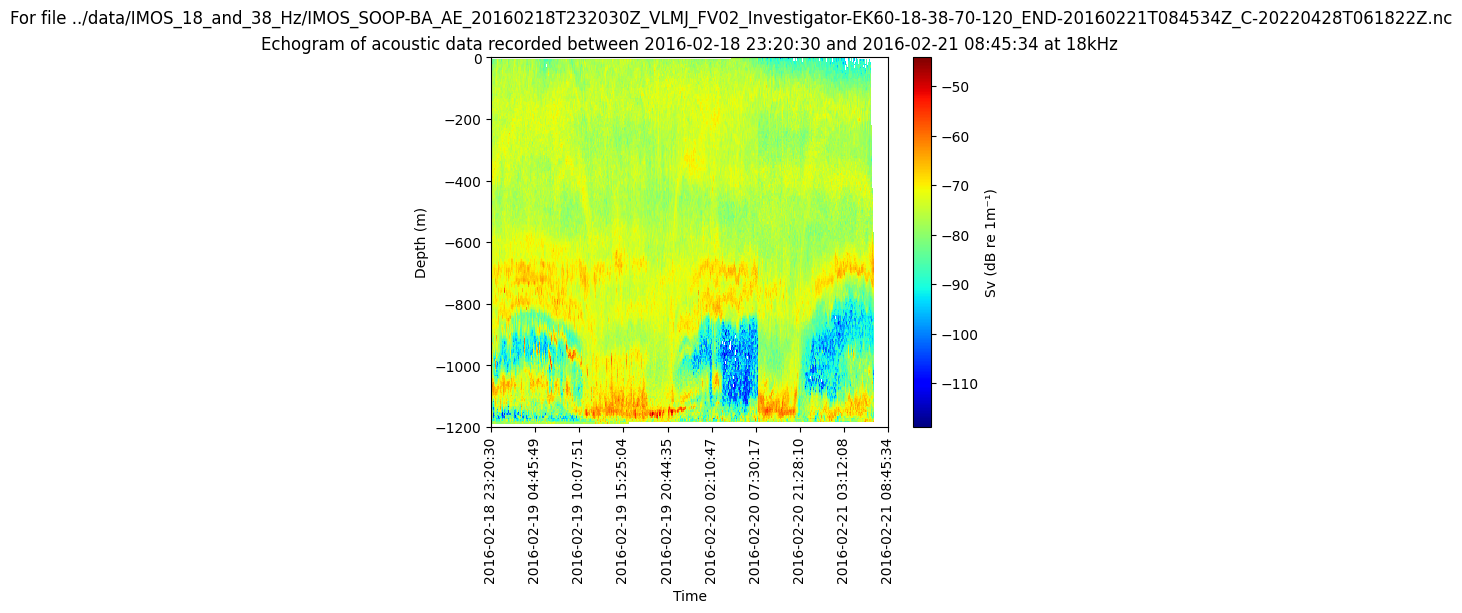

In [264]:
list_cdf_files=script_func.get_list_files() # Open folder containing all nc files and get list of all nc files path
dataset = script_func.open_dataset(3, list_cdf_files) # Open file i
# show_dataset(dataset)
script_func.plot_echogram(dataset, 0, list_cdf_files[3]) # plot echogram of file path (dataset) at freq 0
script_func.close_dataset(dataset) # close dataset

## **2) Time dimension**

### **Test histogram**

There are 10860 samples in 3th dataset


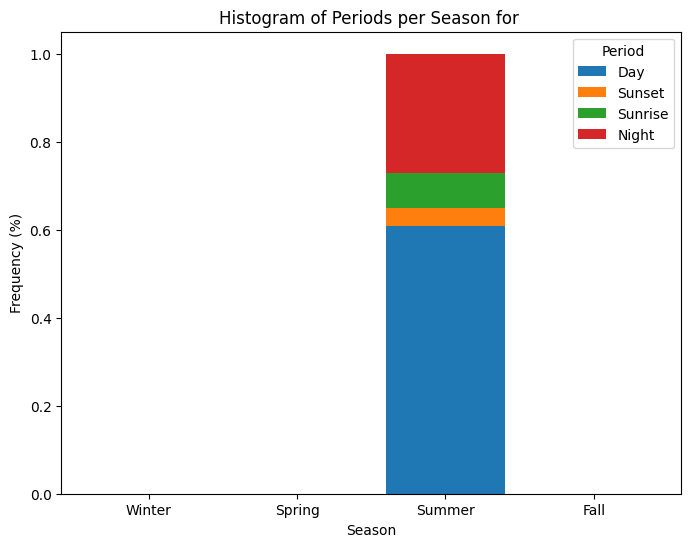

In [39]:
# Test for 1 file
list_cdf_files=script_func.get_list_files() # Open folder containing all nc files and get list of all nc files path
i = 3 # Chose file to open
dataset=script_func.open_dataset(i, list_cdf_files) # Open file i
season_counts  = script_func.count_season(dataset) # Count occurences of period d in season s in file i and 

# Normalization of counts into frequency
n = script_func.get_datetime(dataset).shape[0]
for season in season_counts.keys():
    season_counts[season]=season_counts[season]/n
print(f"There are {n} samples in {i}th dataset") 

script_func.plot_histogram(season_counts) # Plot histogram
dataset.close() # Close dataset

In [40]:
# Test plot histogram on all nc files of folder 

list_cdf_files=script_func.get_list_files() # Open folder containing all nc files and get list of all nc files path
all_seasons_couts, n_all= script_func.count_season_all_files(list_cdf_files) # Open file i
script_func.plot_histogram(all_seasons_couts, save=True, dataset_name="18_and_38_kHz") # Plot histogram
print("There is a total of ", n_all, " samples")

KeyboardInterrupt: 

### **Get depth relatively to frequences of sonar**

In [153]:
def get_depth_depending_on_freq_sonar(dataset:nc.Dataset, freqs:List[str])->np.ndarray[float]: 
    # Get all depth
    depths=dataset['DEPTH'][:] #240 depths

    # Get all acoustic data 
    sv = dataset.variables['Sv'][:]

    # Get total number of samples
    n_samples = sv.shape[0]

    # Get all frequency of interest
    channels=script_func.get_channels(dataset)
    try : 
        index_channels=[channels.index(freq) for freq in freqs]
    except : 
        print("Dataset doesn't contain data at frequency requested")
        return
    
    # Count number of missing data
    n_Nan = np.ma.count_masked(sv, axis=0) # number of NaN for ichannel (240,)
    n_Nan = n_Nan/n_samples # put into frequency
    n_Nan_channels = n_Nan[:, index_channels]

    return n_Nan_channels
    

In [261]:
# def plot_missing_depths(dataset:nc.Dataset, freqs:List[str], missing_data:np.ndarray[float])-> None : 
#     """
#     Plot missing data depending on depth and frequency of recording

#     Parameters : 
#         - dataset : nc.Dataset
#             the full dataset, of shape(n, d, c) n the number of samples, d the number of depth 
#             and c the number of channels (frequencies of recording)
#         - freqs : List[str]
#             the list of frequencies studied for missing data, ex : ['18Hz', '38Hz', '70Hz']
#         - missing_data : np.ndarray[float]
#             the array containing the percentage of missing data, of shape(d, len(freqs))
#     """
#     # Get depths, channels
#     depth = dataset['DEPTH'][:]
#     # depth = -depth # reverse depths
#     # print(depth)
#     channels = script_func.get_channels(dataset)
#     index_channels=[channels.index(freq) for freq in freqs] # the indice of the channel in dataset

#     # Create figure
#     plt.figure(figsize=(10, 6))
#     for i in range(len(freqs)) : 
#         c = index_channels[i]
#         plt.plot(depth, missing_data[:, c], label=f'Fréquence {freqs[i]}')

#     # Put label, title, legend
#     plt.xlabel('Depth (m)')
#     plt.ylabel('Missing data (%)')
#     plt.title('Plot of missing data (%) depending on depth (m) and recording frequency (Hz)')
#     plt.legend()

#     # Save fig
#     plt.savefig(f"./figures/plot_missing_data_depending_on_depth_and_recording_frequence.png", dpi=300, bbox_inches="tight")

#     # Show
#     plt.show()

    

In [262]:
# def plot_missing_depths(dataset:nc.Dataset, freqs:List[str], missing_data:np.ndarray[float])-> None : 
#     """
#     Plot missing data depending on depth and frequency of recording

#     Parameters : 
#         - dataset : nc.Dataset
#             the full dataset, of shape(n, d, c) n the number of samples, d the number of depth 
#             and c the number of channels (frequencies of recording)
#         - freqs : List[str]
#             the list of frequencies studied for missing data, ex : ['18Hz', '38Hz', '70Hz']
#         - missing_data : np.ndarray[float]
#             the array containing the percentage of missing data, of shape(d, len(freqs))
#     """
#     depth = dataset['DEPTH'][:]
#     channels = script_func.get_channels(dataset)
#     index_channels=[channels.index(freq) for freq in freqs] # the indice of the channel in dataset
#     # Create figure
#     plt.figure(figsize=(10, 6))
#     bar_width = 0.4
#     for i in range(len(freqs)) : 
#         c = index_channels[i]
#         x_offset = i * bar_width
#         plt.bar(depth - bar_width / 2 + x_offset, missing_data[:, c], width=bar_width, label=f'Fréquence {freqs[i]}')
#     plt.xlabel('Depth (m)')
#     plt.ylabel('Missing data (%)')
#     plt.title('Plot of missing data (%) depending of depth (m) and recording frequence (Hz)')
#     plt.legend()
#     plt.savefig(f"./figures/hist_unfinished_missing_data_depending_on_depth_and_recording_frequence.png", dpi=300, bbox_inches="tight")
#     plt.show()
    


In [212]:
# test get_depth_depending_on_freq_sonar()
list_cdf_files=script_func.get_list_files()    # Get all netcdf files path of folder chosen
ds = script_func.open_dataset(3, list_cdf_files)    # Open netCDF into nc.Dataset
# print(get_depth_depending_on_freq_sonar(ds, ['38kHz']))
freqs = get_depth_depending_on_freq_sonar(ds, ['18kHz', '38kHz'])

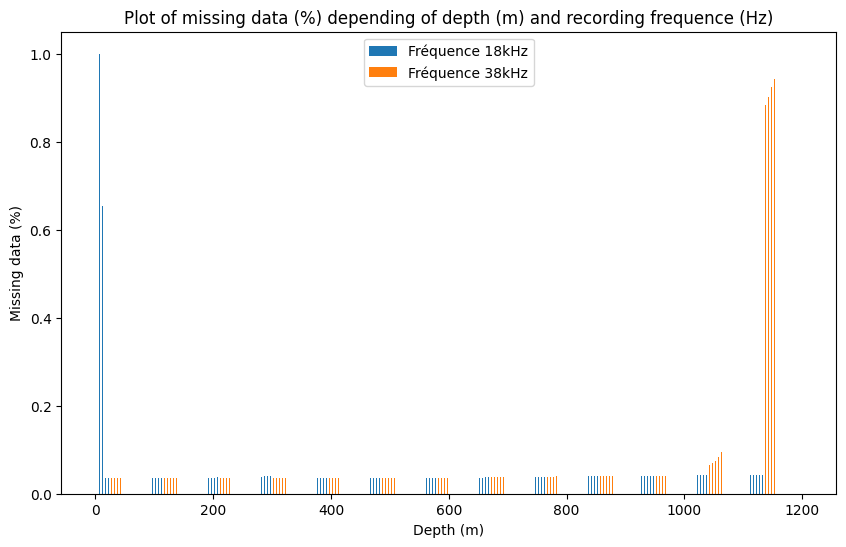

In [263]:
plot_missing_depths(ds,['18kHz', '38kHz'], freqs)

In [ ]:
script_func.close_dataset(ds)     # Close dataset

## **3) Space dimension**

Test cartopy

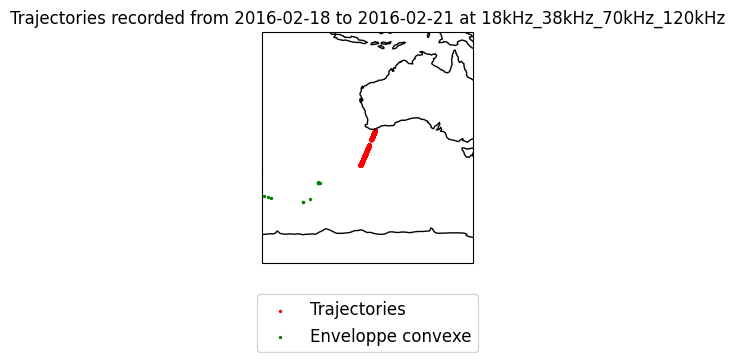

In [ ]:
# Using Cartopy
list_cdf_files=script_func.get_list_files()    # Get all netcdf files path of folder chosen
ds = script_func.open_dataset_xr(3, list_cdf_files)    # Open netCDF into xarray
script_func.display_trajectories(ds, enveloppe=True, save=True)      # Display trajectories
script_func.close_dataset(ds)     # Close dataset